In [352]:
import matplotlib.pyplot as plt
import random
from DataLoader import DataLoader
from FactorCalculator import FactorFunc, FactorCalculator
from ModelTraining import Trainer
from DefaultModel import DefaultModel

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

##  Fetch Stock Codes
##### To optimize runtime, this code samples 300 stock codes from the over 3000 available in the A-share market.

In [ ]:
# Download StockCodes
StockCodes = DataLoader.load_stock_codes()
# For Simplicity select randomly 500 stocks
StockCodes = random.sample(StockCodes, 300)

## Download Data

In [ ]:
# Initialize DataLoader
Loader = DataLoader(StockCodes, start_date='2002-01-01', end_date='2024-07-31')
# Load Spot Price
Loader.load_spot_prices()
# Load Adjusted Price
Loader.load_adjusted_price()
# Load Index Price
Loader.load_index()

## Data Extraction
##### It is recommended to extract 'stock_data' (a dictionary containing DataFrames for individual stocks) for future use.
##### Additionally, 'IndexDict' can be saved for later as a benchmark for evaluating strategy performance.

In [ ]:
# Pass Merged Data to Factor Handler
StockDict = Loader.stock_data
IndexDict = Loader.index_data

## Initialize Feature Calculator and Generate Factors
##### Pass the stock data dictionary from DataLoader directly to the FactorCalculator.
##### The FactorFunc class, referenced in the original paper, contains multiple basic factors used for calculation.

In [ ]:
# Initialize Factor Handler
Calculator = FactorCalculator(StockDict)

In [ ]:
# Create Some Features
Calculator.create_factor(factor_func=FactorFunc.rets,base_col = 'ADJCLOSE', target_col = 'DAYRET')
Calculator.create_factor(factor_func=FactorFunc.rets,base_col = 'IDXCLOSE', target_col = 'IDXRET')
Calculator.create_factor(factor_func=FactorFunc.volatility, base_col = 'DAYRET', target_col = 'RV5D', window = 5)
Calculator.create_factor(factor_func=FactorFunc.ivol, stk_ret_col = 'DAYRET', idx_ret_col = 'IDXRET', target_col = '60DIVOL', window = 60)
Calculator.create_factor(factor_func=FactorFunc.ewm_volatility,
                         base_col = 'DAYRET', target_col = 'MAVOL60D',
                         ewm_param = 5, param_type = 'com')
Calculator.create_factor(factor_func=FactorFunc.illiquidity, ret_col = 'DAYRET', volume_col = 'amount',
                         target_col = 'LIQUIDITY')
Calculator.create_factor(factor_func=FactorFunc.mvel, price_col = 'close', shares_col = 'outstanding_share',
                         target_col = 'MVEL')
Calculator.create_factor(factor_func=FactorFunc.turnover, turn_col = 'turnover', target_col = 'TURNOVER', window = 10)
Calculator.create_factor(factor_func=FactorFunc.mom, ret_col = 'DAYRET', target_col = 'MOM5', window = 5)
Calculator.create_factor(factor_func=FactorFunc.mom, ret_col = 'DAYRET', target_col = 'MOM10', window = 10)
Calculator.create_factor(factor_func=FactorFunc.mom, ret_col = 'DAYRET', target_col = 'MOM15', window = 15)
Calculator.create_factor(factor_func=FactorFunc.mom, ret_col = 'DAYRET', target_col = 'MOM20', window = 20)
Calculator.create_factor(factor_func=FactorFunc.factor_diff, base_col = 'MOM5', target_col = 'CHMOM5')
Calculator.create_factor(factor_func=FactorFunc.factor_diff, base_col = 'MOM10', target_col = 'CHMOM10')
Calculator.create_factor(factor_func=FactorFunc.factor_diff, base_col = 'MOM15', target_col = 'CHMOM15')
Calculator.create_factor(factor_func=FactorFunc.factor_diff, base_col = 'MOM20', target_col = 'CHMOM20')
Calculator.create_factor(factor_func=FactorFunc.maxret, ret_col = 'DAYRET', target_col = 'MAXRET', window = 10)

## Label Creation
##### Generate the label, which is the target variable for the machine learning model.
##### By default, this label represents the actual return of future periods.
# This function is customizable; you can modify the arguments to predict other targets (e.g., volatility).

In [ ]:
# Create Label
Calculator.create_label(ret_col = 'DAYRET', target_col = 'Target', window = 3)

## Concatenate DataFrames
- Merge all individual stock DataFrames into a single DataFrame, using 'date' and 'stockcode' as the index.

In [ ]:
# Concat dataframe for training
Train, Pred = Calculator.concat()

## Specify Training Parameters

In [ ]:
# Specify feature cols
feature_cols = Train.columns.tolist()
removed_cols = ['open', 'high', 'low', 'close', 'volume','amount','outstanding_share','turnover','ADJCLOSE','IDXCLOSE']
for col in removed_cols:
    feature_cols.remove(col)
feature_cols.remove('Target')
# Specify target col
target_col = 'Target'
# Specify date_col
date_col = 'date'
# Specify symbol col
symbol_col = 'stockcode'

## Train the Model
##### Initialize the Trainer with the dataset, feature names, target name, date column name, and symbol (stockcode) column name.
##### The Trainer instance includes a `feature_normalizer()` function that normalizes factors for the same date. By default, this function performs min-max normalization, scaling features to a range of (-1, 1).

In [ ]:
# Initialise Trainer Class
Training =Trainer(dataset=Train,
                  feature_cols = feature_cols, target_col = target_col,
                  date_col = date_col, symbol_col = symbol_col)
# Noramlise features
Training.feature_normalizer()

In [ ]:
# Set the training window
Training.set_train_window()

## Initialize Default Model
##### The Trainer instance includes a `train_model` method, which accepts TensorFlow models; any compiled custom model is also supported.
##### The `DefaultModel` offers four pre-defined models: a simple Neural Network, LSTM, RNN, and GRU.

In [ ]:
# Initialse Models class
Models = DefaultModel()

# Use default LSTM, default 20 steps
input_shape = (20, len(feature_cols))
Models.create_default_LSTM(input_shape=input_shape)

## Train the Model

In [ ]:
# Train the model
Train_rec = Training.train_model(model = Models.default_LSTM,
                                 rnn_type=True, seq_length=20,
                                 val_ratio=0.05, return_train_record=True, epochs=1)

In [354]:
Train_rec = Train_rec.history

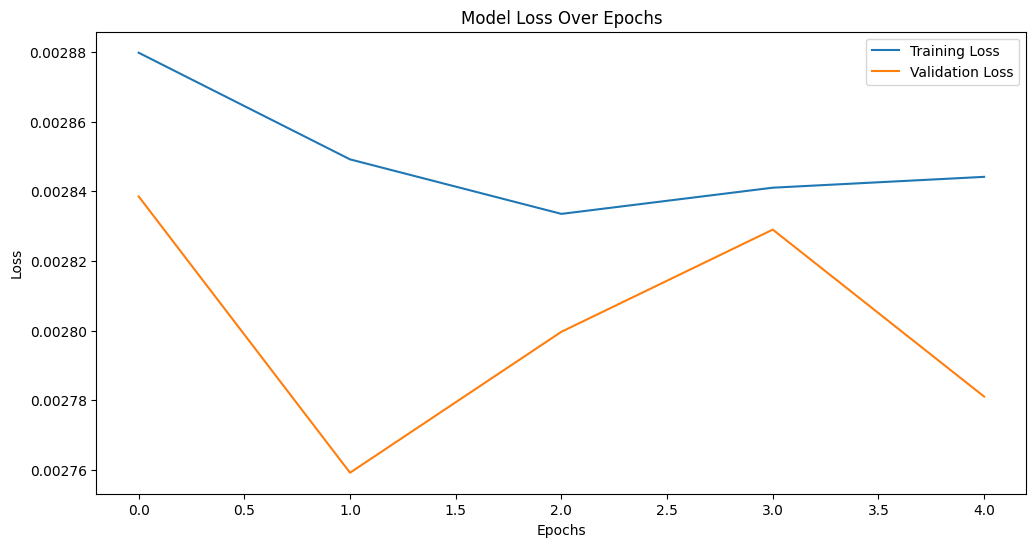

In [355]:
# Visualize Training History
# Plotting Loss
plt.figure(figsize=(12, 6))

plt.plot(Train_rec['loss'], label='Training Loss')
plt.plot(Train_rec['val_loss'], label='Validation Loss')

# Adding title and labels
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

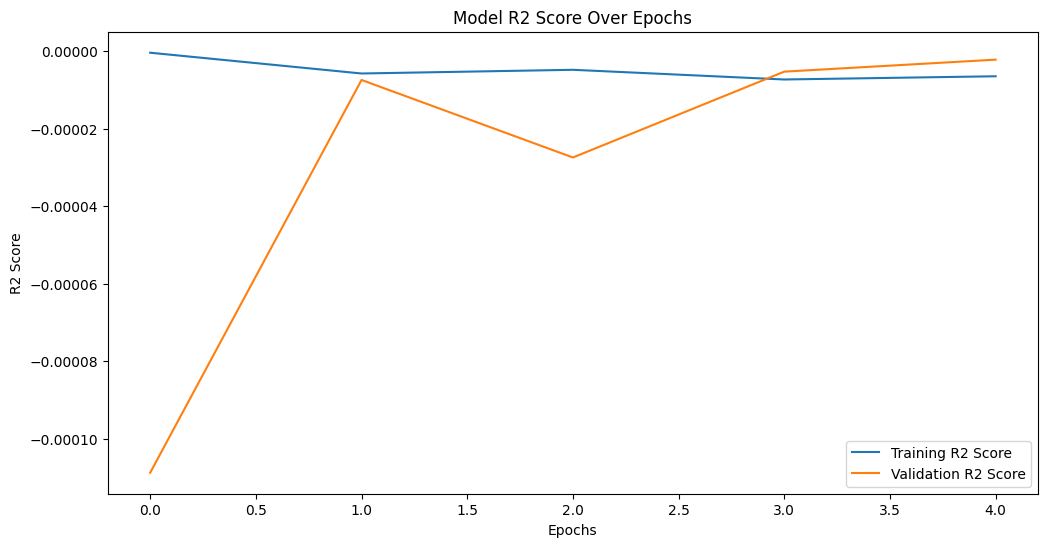

In [358]:
# Plot Accuracy
wplt.figure(figsize=(12, 6))

# Training accuracy
plt.plot(Train_rec['r2_score'], label='Training R2 Score')
plt.plot(Train_rec['val_r2_score'], label='Validation R2 Score')

# Adding title and labels
plt.title('Model R2 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.legend()

# Display the plot
plt.show()

##### Due to computational resource constraints, this sample uses only 300 stocks for training. 
##### This limitation significantly affects the training results, leading to an R² score slightly below zero, indicating no predictive power.
##### However, with a larger dataset and more factors, you should expect to see better predictive performance.
##### The entire process replicates the methodology outlined in the paper:
- Gu, Shihao, Bryan Kelly, and Dacheng Xiu. “Empirical Asset Pricing via Machine Learning.” Journal Name Volume, no. Issue (Year): Page Range. https://doi.org/DOI.

## Iterate and Train
##### Given the selected training period for the base model, the following code allows you to iterate through the remaining data in chronological order.
##### At each iteration, the model performs out-of-sample predictions using features from one step beyond the training window.
##### This function returns three values:
    - `Training.iter_metric_history`: Records the R² Score (or other user-customized metrics) throughout the iterations.
    - `Training.return_predictions`: Logs the predicted returns along with the true returns at each step, useful for portfolio construction.
    - `Training.iter_history`: Saves the model's fit history, including loss and other metrics.
##### Due to resource constraints, this code was not executed, as fitting a model with insufficient data would be largely ineffective.

In [ ]:
# Iter the model
Training.iter_model(rolling_type='expanding')